In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:

import ANSStools as atp

import pylab as plt
import numpy
import scipy
import datetime as dtm
import pytz
from mpl_toolkits.basemap import Basemap as Basemap



In [ ]:
class Simple_Catalog(object):
    def __init__(self, lats=[-125,-125], lons=[31., 41.], m_c=1.5, t0=dtm.datetime(1990,1,1, tzinfo=pytz.utc), 
                 t=dtm.datetime.now(pytz.utc), n_max=None, mapres='i'):
        if lats is None: lats=[]
        if lons is None: lons=[]
        if len(lats)<1: lats.append(float(input('lower latitude: ')))
        if len(lats)<2: lats.append(float(input('upper latitute: ')))
        if len(lons)<1: lons.append(float(input('lower longitude: ')))
        if len(lons)<2: lons.append(float(input('upper longitude: ')))
        if m_c is None or m_c=='': m_c = (input('m_c[1.5]: '), 1.5)
        #
        # dates will be a little bit trickier; we probably need to process strings. find the date-handler code.
        #
        self.__dict__.update(locals())
        catalog = atp.catfromANSS(lon=lons, lat=lats, minMag=m_c, dates0=[t0, t], Nmax=n_max,
                                  fout=None, rec_array=True)
    #
    def simple_map(self, fignum=None, fig=None, ax=None, lats=None, lons=None, mapres=None):
        if lats is None: lats = self.lats
        if lons is None: lons = self.lons
        if ax is None:
            if fig is None:
                fignum = (fignum or 0)
                fig = plt.figure(fignum)
            #
            ax=plt.gca()
        #
        mapres=(mapres or self.mapres)
        #
        lllat = lats[0]
        urlat = lats[1]
        lllon = lons[0]
        urlon = lons[1]
        print('lls: ', lons, lats)
        lon0 = numpy.mean(lons)
        lat0 = numpy.mean(lats)
        bm = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, resolution=mapres,
                     projection='cyl', lon_0=lon0, lat_0=lat0, ax=ax)
        bm.drawcountries()
        bm.drawrivers()
        #
        # draw coastlines and fill continents.
        bm.drawcoastlines()
        # fill continents and lakes
        bm.fillcontinents(color='coral',lake_color='aqua')
        # draw political boundaries.
        bm.drawcountries(linewidth=1)
        # fill map projection region light blue (this will
        # paint ocean areas same color as lakes).
        bm.drawmapboundary(fill_color='aqua')
        # draw major rivers.
        bm.drawrivers(color='b')
        #print(time.clock()-t1,' secs to plot using using a pickled Basemap instance')
        # draw parallels
        #
        # need a smart way to guess meridians. maybe an integer math routine to choose[.1, .25, .5, 1., 5., 10.]
        #bm.drawparallels(circles,labels=[1,1,0,0])
        # draw meridians
        meridians = numpy.arange(-12,13,2)
        bm.drawmeridians(meridians,labels=[0,0,1,1])
        
        self.bm=bm
        

In [4]:
L = 10**(.5*7.8-1.76)
print(L)


138.03842646028838


lls:  [168.077, 178.077] [37.757, 47.757]


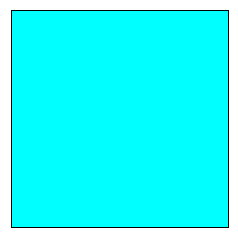

In [5]:
# NZ 2016:
# 2016-11-13 11:02:56 (UTC)
#Location
#42.757°S 173.077°E
lon0 = 173.077
lat0=42.757
dlon=5.
dlat=5.
#
lons = [lon0-5., lon0+5.]
lats = [lat0-5., lat0+5.]
cm = Simple_Catalog(lats=lats, lons=lons)


cm.simple_map()

In [6]:
# new zealand catalog:
# see starting url at geonet:
#  http://quakesearch.geonet.org.nz/ 
# queries are by simple query-string, so just put together one query with one of each condition, then we can paste
# this together.
# http://quakesearch.geonet.org.nz/csv?bbox=168.,-47.5,178.,-37.5&minmag=1.5&maxmag=11.0&mindepth=1.&maxdepth=100.0&startdate=2016-10-13T20:00:00&enddate=2016-11-13T22:00:00

#### New ANSS-comcat web api
- Avoid needing to load the bulky comcat library (which can be a problem in HPC environments)
- Instead, just hack the web api


In [8]:
#
# test new comcat API:
tzutc=atp.tzutc

mc = 2.5
t0 = dtm.datetime(2017,8,15, tzinfo=tzutc)
cat_cc = atp.cat_from_comcat(dates0=[t0, dtm.datetime(2019,9,12, tzinfo=tzutc)],
                            minMag=mc, lat=[31., 35.], lon=[-122., -112.], rec_array=True)

cat_anss_cc = atp.cat_from_anss_comcat(dates0=[t0, dtm.datetime(2019,9,12, tzinfo=tzutc)],
                            minMag=mc, lat=[31., 35.], lon=[-122., -112.], rec_array=True)
#
print('** lens: ', len(cat_cc), len(cat_anss_cc))
#
#
#print('** cc\n', cat_cc)
#print('** anss_cc\n', cat_anss_cc)
#
print('Evaluating: ')
k_ex = 0
for k, (rw1, rw2) in enumerate(zip(cat_cc, cat_anss_cc)):
    #print('* {}: {}'.format(k, list(rw1)==list(rw2)))
    #print('** * ', list(rw1)[1:])
    #print('* ** ', list(rw2)[1:])
    if not ( list(rw1)[1:] == list(rw2)[1:] ):
        print('*** EXCEPTION:: \n {}\n{}\n{}\n{}'.format(rw1, rw2, [x1==x2 for x1, x2 in zip(rw1, rw2)],
                                                [(x1-x2)/(x1+x2) for x1, x2 in zip(list(rw1)[1:], list(rw2)[1:])]))
        k_ex += 1
print('*** {}/{}'.format(k_ex, k))

** lens:  656 656
Evaluating: 
*** EXCEPTION:: 
 ('2019-09-03T00:30:33.050000', 34.4531667, -118.4865, 2.71, 17.6, 737305.02121586)
('2019-09-03T00:30:33.050001', 34.4531667, -118.4865, 2.71, 17.6, 737305.02121586)
[False, True, True, True, True, False]
[0.0, -0.0, 0.0, 0.0, -7.894651363892758e-17]
*** 1/655
